In [3]:
#Used for displaying plots below the cell
%matplotlib inline
import math

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats.stats import pearsonr

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

In [4]:
df_geo = pd.read_csv('./geography.csv', sep=',', index_col=0)
df_ram = pd.read_csv('./ram.csv', sep=',', index_col=0)

# Original dataset split for VCS purposes
df_sales_part1 = pd.read_csv('./sales_ram-part1.csv', sep=',', index_col=0) #The dataset doesn't have a column name. This causes the error.
df_sales_part2 = pd.read_csv('./sales_ram-part2.csv', sep=',', index_col=0)
df_sales = df_sales_part1.append(df_sales_part2)

df_time = pd.read_csv('./time.csv', sep=',', index_col=0)
df_vendor = pd.read_csv('./vendor.csv', sep=',', index_col=0)

/home/avenger/.local/lib/python3.9/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


# Task 1.1: Data understanding

In this section we will go through all the datasets imported and try to mine some interesting information.

## Geography

In [5]:
df_geo.head()

,geo_code,continent,country,region,currency
1,1,Oceania,Australia,northern territory,AUD
2,2,Oceania,Australia,queensland,AUD
3,3,Oceania,Australia,south australia,AUD
4,4,Oceania,Australia,tasmania,AUD
5,5,Oceania,Australia,victoria,AUD


In [6]:
print(f"Continents in the dataset: {df_geo['continent'].unique()}")

Continents in the dataset: ['Oceania' 'Europe' 'America']


In [7]:
print(f"Countries in the dataset: {df_geo['country'].unique()}")

Countries in the dataset: ['Australia' 'Belgium' 'Canada' 'Germany' 'Spain' 'France' 'Ireland'
 'Italy' 'New Zeland' 'United Kingdom' 'United States of America']


In [8]:
print(f"Regions in the dataset: {df_geo['region'].unique()}")

Regions in the dataset: ['northern territory' 'queensland' 'south australia' 'tasmania' 'victoria'
 'western australia' 'brussels' 'flanders' 'wallonia' 'atlantic provinces'
 'british columbia' 'ontario' 'prairie provinces' 'quebec' 'the north'
 'baden-wuttemberg' 'bavaria' 'berlin' 'brandenburg' 'bremen' 'hamburg'
 'hessen' 'lower saxony' 'mecklenburg-vorpommern' 'north rhine-westphalla'
 'rhineland-palatinate' 'saarland' 'saxony' 'saxony-anhalt'
 'schleswig-holstein' 'thuringia' 'analucia' 'aragon' 'asturleon'
 'castilla' 'galicia' 'vascongadas' 'heart of france' 'le midi france'
 'north east france' 'north west france' 'southwest france'
 'upland france' 'connaught' 'leinster' 'munster' 'ulster' 'center italy'
 'north italy' 'south italy' 'north island-central east'
 'north island-central west' 'north island-southern'
 'northern island-northern' 'south island northern' 'south island-central'
 'south island-southern' 'east england' 'east midlands' 'london'
 'north east england' 'nort

In [9]:
print(f"Currencies in the dataset: {df_geo['currency'].unique()}")

Currencies in the dataset: ['AUD' 'EUR' 'CAD' 'NZD' 'GBP' 'USD']


In [10]:
print(df_geo["geo_code"].duplicated().any())

False


In [11]:
df_geo.groupby(["continent","country", "region", "currency"]).size().describe()

count    75.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
dtype: float64

Each combination of attributes in the dataset is unique, therefore there are no entries with different geo_code but same content.

In [12]:
print(df_geo["continent"].isna().any())
print(df_geo["country"].isna().any())
print(df_geo["region"].isna().any())
print(df_geo["currency"].isna().any())

False
False
False
False


No missing values in sight.

## Ram

In [13]:
df_ram.head()

,brand,name,memory,memory_type,clock
ram_code,,,,,
2,ADATA,Adata,1.0,DDR,333
1,ADATA,Adata,0.5,DDR,400
3,ADATA,Adata,1.0,DDR,400
4,ADATA,Adata,2.0,DDR,400
5,ADATA,Adata,1.0,DDR2,667


In [14]:
print(f'Ram brands: {df_ram["brand"].unique()}')

Ram brands: ['ADATA' 'AENEON' 'AFOX' 'AMD' 'APACER' 'APOTOP' 'AVEXIR' 'BUFFALO'
 'COMPUSTOCX' 'CORSAIR' 'CRUCIAL' 'DANE-ELEC' 'DELL' 'EDGE' 'ELIXIR'
 'EVGA' 'EXTREMEMORY' 'G.SKILL' 'GALAX' 'GALAX/KFA2' 'GEIL' 'GLOWAY'
 'GOODRAM' 'HP' 'HYNIX' 'IBM' 'INTEGRAL' 'INTENSO' 'KFA&SUP2' 'KINGMAX'
 'KINGSTON' 'KLEVV' 'LEXAR' 'MDT' 'MICRON' 'MUSHKIN' 'MUSTANG' 'NILOX'
 'OCZ' 'PANRAM' 'PAREEMA' 'PATRIOT' 'PNY' 'SAMSUNG' 'SILICON' 'SK' 'SUPER'
 'TEAM GROUP' 'TOSHIBA' 'TRANSCEND' 'V7' 'VISIONTEK' 'WINTEC' 'XPG']


In [15]:
print(f'Ram names: {df_ram["name"].unique()}')

Ram names: ['Adata' 'Adata Gaming' 'Adata Performance Value' 'Adata Plus'
 'Adata Premier' 'Adata Supreme' 'Adata Value' 'Adata Xpg Dazzle'
 'Adata Xpg Flame' 'Adata Xpg Gaming' 'Adata Xpg Gammix D10'
 'Adata Xpg Plus' 'Adata Xpg Spectrix D40' 'Adata Xpg V1.0' 'Adata Xpg V2'
 'Adata Xpg V3' 'Adata Xpg Z1' 'Aeneon' 'Afox' 'Amd'
 'Amd Entertainment Edition' 'Amd Performance Edition' 'Amd R3 Value'
 'Amd R5 Entertainment' 'Amd R7 Performance' 'Amd R9 2400' 'Amd R9 Gamer'
 'Amd Rg2133 Gamer' 'Apacer' 'Apacer Armor' 'Apacer Black Panther'
 'Apacer Blade' 'Apacer Blade Fire' 'Apacer Commando' 'Apacer Nox'
 'Apacer Panther' 'Apacer Thunderbird Blue' 'Apotop' 'Avexir'
 'Avexir Apple Memory' 'Avexir Blitz' 'Avexir Blitz 1.1' 'Avexir Budget'
 'Avexir Core' 'Avexir Green' 'Avexir Mpower' 'Avexir Notebook'
 'Avexir Platinum' 'Avexir Raiden' 'Avexir Rog' 'Avexir Server'
 'Avexir So' 'Avexir Standard' 'Buffalo' 'Compustocx' 'Corsair'
 'Corsair Dominator' 'Corsair Fb' 'Corsair Mac Memory' 'Corsair Pl

In [16]:
print(f'Ram memory type: {df_ram["memory_type"].unique()}')

Ram memory type: ['DDR' 'DDR2' 'DDR3' 'DDR4' 'DDR3L' 'SDR' 'DDR3U']


In [17]:
df_ram.describe()

,memory,clock
count,3705.000000,3705.000000
mean,16.280938,1969.170040
std,20.422881,797.256751
min,0.125000,100.000000
25%,4.000000,1333.000000
50%,8.000000,1866.000000
75%,16.000000,2400.000000
max,256.000000,4600.000000


The values are all within reasonable range, there are no obvious outliers.

In [18]:
print(df_ram["brand"].isna().any())
print(df_ram["name"].isna().any())
print(df_ram["memory_type"].isna().any())

False
False
False


No missing values.

In [19]:
df_ram.corr()

,memory,clock
memory,1.000000,0.331674
clock,0.331674,1.000000


The RAMs included in the dataset do not have a correlation between their clock and memory capacity. 

## Sales

In [20]:
df_sales.head()

,Id,ram_code,time_code,geo_code,vendor_code,sales_uds,sales_currency
2602347,3719,1.0,20130322,25,32,13.749032,10.65
2602348,3719,1.0,20130323,18,32,13.828708,10.65
2602349,3719,1.0,20130326,28,32,13.694297,10.65
2602350,3719,1.0,20130327,25,32,13.690530,10.65
2602351,3719,1.0,20130328,27,32,13.605216,10.65


In [21]:
df_sales.describe()

,Id,ram_code,time_code,geo_code,vendor_code,sales_uds,sales_currency
count,3.412331e+06,3.412331e+06,3.412331e+06,3.412331e+06,3.412331e+06,3.412331e+06,3.412331e+06
mean,5.257606e+03,1.539606e+03,2.016166e+07,3.293352e+01,3.949093e+01,1.814250e+02,1.590673e+02
std,8.536889e+02,8.536889e+02,1.309320e+04,1.896925e+01,1.416273e+01,8.536833e+03,5.426377e+03
min,3.719000e+03,1.000000e+00,2.013032e+07,1.000000e+00,1.000000e+00,7.050645e-01,5.000000e-01
25%,4.522000e+03,8.040000e+02,2.015112e+07,2.000000e+01,3.200000e+01,4.858296e+01,4.202000e+01
50%,5.141000e+03,1.423000e+03,2.016111e+07,2.600000e+01,3.200000e+01,9.906795e+01,8.760000e+01
75%,5.957000e+03,2.239000e+03,2.017081e+07,3.200000e+01,4.500000e+01,2.058690e+02,1.829000e+02
max,7.422000e+03,3.704000e+03,2.018041e+07,7.500000e+01,8.100000e+01,1.574134e+07,1.000000e+07


In order to make the analysis process easier we will merge all of the datasets into a single one.

In [22]:
df_sales_merged = df_sales[["Id", "ram_code"]].join(df_ram, on="ram_code", rsuffix="_ram")
df_sales_merged["time_code"] = df_sales["time_code"]
df_sales_merged = df_sales_merged.join(df_time.set_index("time_code"), on="time_code")
df_sales_merged["geo_code"] = df_sales["geo_code"]
df_sales_merged = df_sales_merged.join(df_geo.set_index("geo_code"), on="geo_code")
df_sales_merged["vendor_code"] = df_sales["vendor_code"]
df_sales_merged = df_sales_merged.join(df_vendor.set_index("vendor_code"), on="vendor_code", rsuffix="_vendor")
df_sales_merged = df_sales_merged.join(df_sales[["sales_uds", "sales_currency"]])

In [23]:
df_sales_merged.head()

,Id,ram_code,brand,name,memory,memory_type,clock,time_code,year,month,...,week,geo_code,continent,country,region,currency,vendor_code,name_vendor,sales_uds,sales_currency
2602347,3719,1.0,ADATA,Adata,0.5,DDR,400,20130322,2013,3,...,12,25,Europe,Germany,north rhine-westphalla,EUR,32,geizhals_unknown,13.749032,10.65
2602348,3719,1.0,ADATA,Adata,0.5,DDR,400,20130323,2013,3,...,12,18,Europe,Germany,berlin,EUR,32,geizhals_unknown,13.828708,10.65
2602349,3719,1.0,ADATA,Adata,0.5,DDR,400,20130326,2013,3,...,13,28,Europe,Germany,saxony,EUR,32,geizhals_unknown,13.694297,10.65
2602350,3719,1.0,ADATA,Adata,0.5,DDR,400,20130327,2013,3,...,13,25,Europe,Germany,north rhine-westphalla,EUR,32,geizhals_unknown,13.690530,10.65
2602351,3719,1.0,ADATA,Adata,0.5,DDR,400,20130328,2013,3,...,13,27,Europe,Germany,saarland,EUR,32,geizhals_unknown,13.605216,10.65


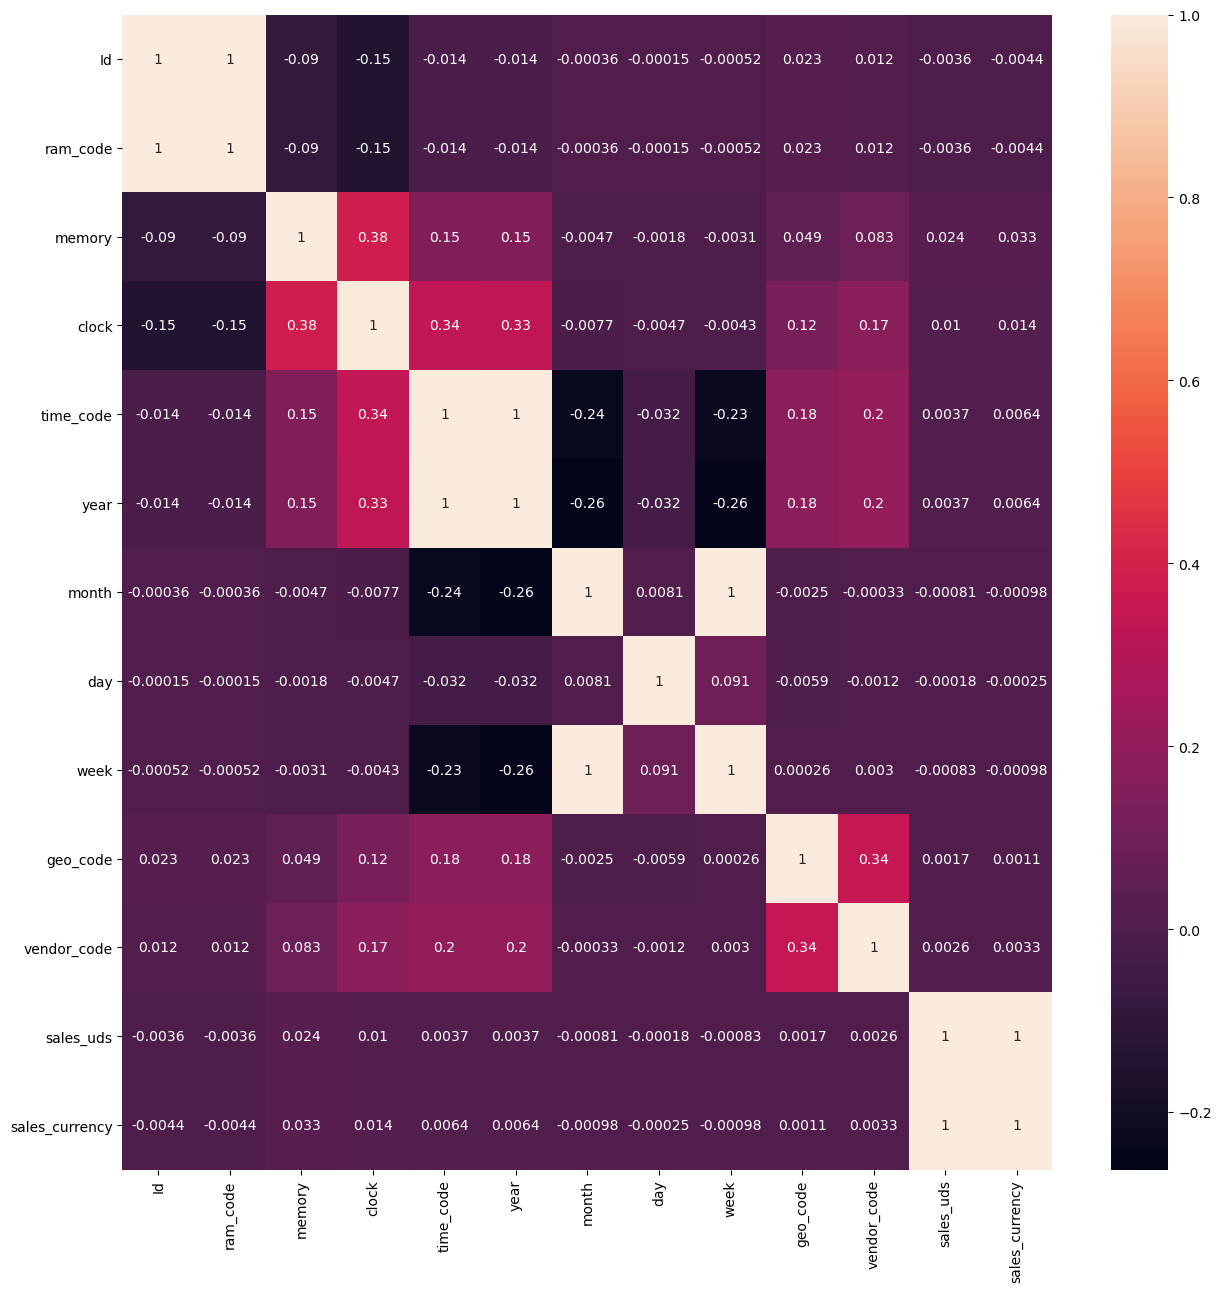

In [24]:
num_sales_df = df_sales_merged.drop(["brand", "name", "memory_type", "continent", "country", "region", "currency", "name_vendor"], axis=1)
plt.figure(figsize=(15,15))
sn.heatmap(num_sales_df.corr(), annot=True)
plt.show()

The majority of the correlation coefficients present are irrelevant, some however give us some information about the meaning of the data:  
- (ram_code, id): it implies that there is a 1-to-1 relationship between them, in other words for each id we have a single ram_code and viceversa.  
    One of these is redundant.
- (sales_uds, sales_currency): interesting indicator of the stability of the currencies, implies that the usd lost value only when the others lost it.  
    Probably due to the presence of strong currencies only.
- (week, month): this correlation is a given since month is about week/4.  

In [25]:
df_sales_merged.dtypes

Id                  int64
ram_code          float64
brand              object
name               object
memory            float64
memory_type        object
clock               int64
time_code           int64
year                int64
month               int64
day                 int64
week                int64
geo_code            int64
continent          object
country            object
region             object
currency           object
vendor_code         int64
name_vendor        object
sales_uds         float64
sales_currency    float64
dtype: object

The data types are as expected, all of the strings are being treated as generic objects.  
For the purposes of our analysis this is irrelevant.

### Id/ram_code meaning  
Given that Id/ram_code have virtually the same use, we want to check the relationship between them and the vendors.

In [26]:
df_sales_merged.groupby("vendor_code")["ram_code"].unique()

vendor_code
1     [448.0, 496.0, 497.0, 498.0, 507.0, 509.0, 510...
2     [113.0, 115.0, 117.0, 120.0, 144.0, 145.0, 146...
3     [48.0, 432.0, 433.0, 434.0, 435.0, 436.0, 437....
4     [48.0, 432.0, 433.0, 435.0, 436.0, 437.0, 438....
5     [15.0, 18.0, 19.0, 20.0, 21.0, 23.0, 24.0, 25....
                            ...                        
77    [444.0, 547.0, 549.0, 550.0, 552.0, 553.0, 659...
78    [225.0, 226.0, 227.0, 229.0, 230.0, 231.0, 232...
79    [432.0, 435.0, 437.0, 438.0, 439.0, 440.0, 441...
80    [14.0, 43.0, 97.0, 101.0, 108.0, 110.0, 143.0,...
81          [858.0, 861.0, 974.0, 976.0, 978.0, 1591.0]
Name: ram_code, Length: 78, dtype: object

The same vendor can have products with different ram_codes.  

In [27]:
df_sales_merged.groupby("ram_code")["vendor_code"].unique()

ram_code
1.0           [32]
2.0           [32]
3.0           [32]
4.0           [32]
5.0       [32, 68]
            ...   
3699.0        [47]
3700.0    [47, 49]
3701.0        [47]
3703.0        [47]
3704.0        [47]
Name: vendor_code, Length: 3119, dtype: object

Each product identified by ram_code can be sold by different vendors.

### sales_uds meaning
The name seems to indicate that it is the value in US dollars of the item, but let's check just to be safe.

In [28]:
diff_currency_series = (df_sales["sales_uds"]-df_sales["sales_currency"]).abs()
diff_currency_series.describe()

count    3.412331e+06
mean     3.205447e+01
std      3.111678e+03
min      0.000000e+00
25%      5.442805e+00
50%      1.435573e+01
75%      3.489960e+01
max      5.741338e+06
dtype: float64

A min value of 0 indicates that there are some rows in which the two values (sales_uds, sales_currency) are identical.  
Let's find out for which countries this property holds.

In [29]:
df_diff_country = df_sales.loc[diff_currency_series == 0].set_index("geo_code").join(df_geo.set_index("geo_code"))
df_diff_country.head()

,Id,ram_code,time_code,vendor_code,sales_uds,sales_currency,continent,country,region,currency
geo_code,,,,,,,,,,
69,3726,8.0,20170120,52,30.44,30.44,America,United States of America,mid-atalntic,USD
69,3726,8.0,20170216,52,30.31,30.31,America,United States of America,mid-atalntic,USD
69,3726,8.0,20170422,52,30.57,30.57,America,United States of America,mid-atalntic,USD
69,3726,8.0,20170423,52,30.57,30.57,America,United States of America,mid-atalntic,USD
69,3726,8.0,20170426,52,30.83,30.83,America,United States of America,mid-atalntic,USD


In [30]:
df_diff_country["country"].unique()

array(['United States of America'], dtype=object)

Given that the only country in the dataset that has sales_usd always equal to sales_currency is the US this confirms our intuition.

### geo_code meaning

In [31]:
df_sales_merged.groupby("vendor_code")["geo_code"].unique()

vendor_code
1                          [56, 53, 54, 58, 57, 55, 52]
2                          [72, 69, 75, 74, 73, 71, 70]
3     [36, 34, 39, 44, 35, 42, 40, 33, 41, 37, 43, 3...
4                                          [49, 51, 50]
5     [68, 61, 60, 63, 66, 59, 65, 2, 67, 64, 32, 17...
                            ...                        
77                                [5, 4, 6, 2, 3, 7, 1]
78                         [74, 73, 71, 72, 70, 75, 69]
79                                [2, 3, 4, 7, 5, 1, 6]
80                             [14, 12, 16, 11, 13, 15]
81          [59, 62, 68, 64, 2, 63, 60, 61, 67, 65, 66]
Name: geo_code, Length: 78, dtype: object

From this results we can infer that the relationship between geo_code and vendor_code is many-to-many.

### currency meaning

In [114]:
df_sales_merged.groupby("vendor_code")["currency"].unique()

vendor_code
1          [NZD, GBP]
2               [USD]
3               [EUR]
4          [EUR, NZD]
5     [GBP, AUD, EUR]
           ...       
77         [AUD, EUR]
78              [USD]
79         [AUD, EUR]
80         [CAD, EUR]
81         [GBP, AUD]
Name: currency, Length: 78, dtype: object

Many vendors also sell internationally.

### Relationship between ram characteristics and price  (TODO: complete)  
In this section we look into the correlation between the features of a RAM module and its price.

In [32]:
df_sales_merged.corrwith(df_sales_merged["sales_uds"])[["memory", "clock"]]

memory    0.023777
clock     0.010018
dtype: float64

It seems that there is no correlation between memory/clock characteristics and sales_uds.  
This seems counterintuitive given that this features should, together with the brand name and the memory type, be the main contributors to the price of ram.  
Let's check that aren't any problematic situations in the dataset.

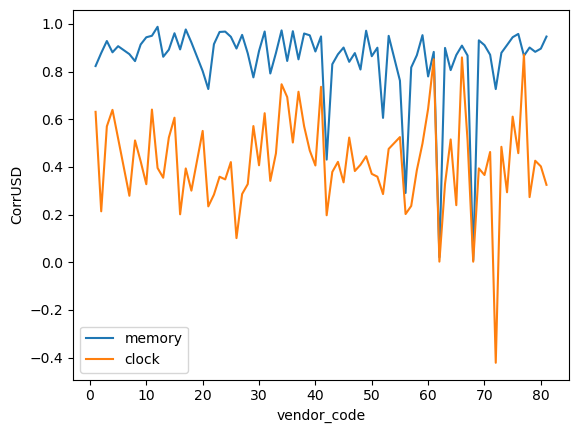

In [109]:
df_sales_merged.groupby("vendor_code")[["memory", "clock"]].corrwith(df_sales_merged["sales_uds"]).plot()
plt.ylabel("CorrUSD")
plt.show()

However, when grouping by vendor_code the correlation between characteristics and price is very strong except for a few vendors.  
In general the clock is not as strongly correlated, positively or negatively, to the price of the ram as it can be seen from the distribution of the correlations.

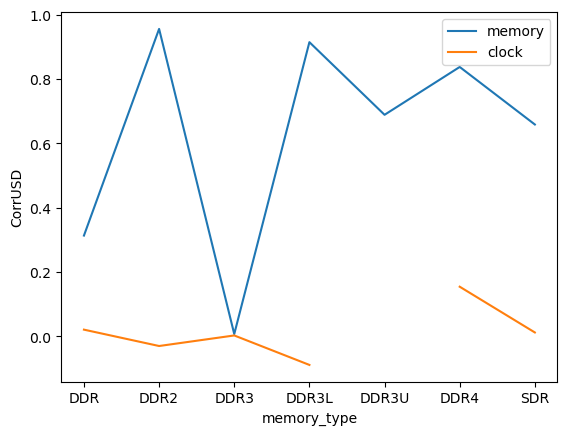

In [108]:
df_sales_merged.groupby(["memory_type"])[["memory", "clock"]].corrwith(df_sales_merged["sales_uds"]).plot()
plt.ylabel("CorrUSD")
plt.show()

The variance of the clock in DDR3U is 0 (1600 MHz), therefore the correlation is not defined.

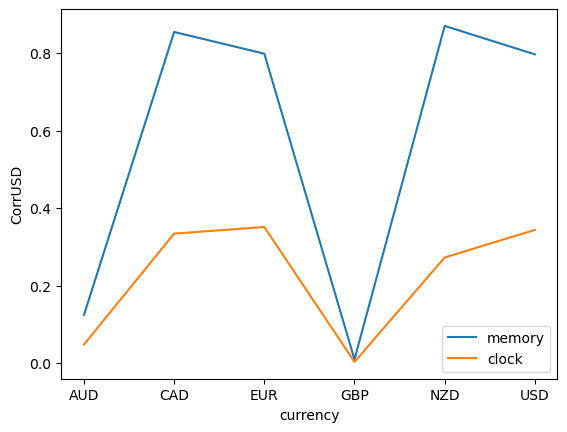

In [132]:
df_sales_merged.groupby(["currency"])[["memory", "clock"]].corrwith(df_sales_merged["sales_uds"]).plot()
plt.ylabel("CorrUSD")
plt.show()

Whatever the problem is it seems connected with specific countries/currencies.

In [143]:
df_sales_merged.groupby(["currency", "year"])[["memory", "clock"]].corrwith(df_sales_merged["sales_uds"])

memory     clock
currency year                    
AUD      2015  0.023236  0.006309
         2016  0.899381  0.300163
         2017  0.923857  0.370994
         2018  0.946665  0.405175
CAD      2016  0.890657  0.322954
         2017  0.919955  0.311594
         2018  0.916343  0.388417
EUR      2013  0.374491  0.149974
         2014  0.849123  0.387886
         2015  0.843672  0.363067
         2016  0.744658  0.280514
         2017  0.922631  0.387642
         2018  0.941131  0.420904
GBP      2015 -0.000090 -0.000629
         2016  0.101807  0.028168
         2017  0.891440  0.340756
         2018  0.947994  0.386289
NZD      2016  0.807473  0.134685
         2017  0.932658  0.260207
         2018  0.959330  0.346143
USD      2016  0.854878  0.339390
         2017  0.823997  0.338832
         2018  0.881339  0.395012

The correlation (memory-wise) for GBP and AUD is low for the first years of sales (2015/2016), the other countries have an high correlation average (note the smallish correlation for EUR/2013).  
Let's take a deeper dive.

In [161]:
df_sales_merged.loc[(df_sales_merged["currency"] == "GBP") & (df_sales_merged["year"].isin([2015,2016]))].groupby(["year", "month"])[["memory", "clock"]].corrwith(df_sales_merged["sales_uds"])

memory     clock
year month                    
2015 3      0.875569  0.368029
     4      0.864059  0.405992
     5     -0.009810 -0.003235
     6      0.812650  0.295316
     7      0.881608  0.310882
     8      0.890568  0.274117
     9      0.871007  0.260590
     10     0.872607  0.261615
     11     0.892632  0.333730
     12     0.898498  0.279362
2016 1      0.904946  0.334982
     2      0.929666  0.265252
     3      0.921551  0.240826
     4      0.907286  0.284296
     5      0.019325  0.000855
     6      0.865692  0.225660
     7      0.887550  0.235913
     8      0.882657  0.224820
     9      0.917329  0.295377
     10     0.935796  0.302537
     11     0.937805  0.297607
     12     0.941592  0.303434

During the month of May 2015/2016 the correlation takes a nosedive, otherwise it stays fairly high.

In [164]:
df_sales_merged.loc[(df_sales_merged["currency"] == "AUD") & (df_sales_merged["year"] == 2015)].groupby(["year", "month"])[["memory", "clock"]].corrwith(df_sales_merged["sales_uds"])

memory     clock
year month                    
2015 3      0.836894  0.455765
     4     -0.027701 -0.008275
     5      0.815812  0.414578
     6      0.904482  0.309631
     7      0.863830  0.334913
     8      0.849775  0.307584
     9      0.886038  0.293943
     10     0.800210  0.135589
     11     0.896992  0.272824
     12     0.906423  0.292591

Similar situation for the AUD, here it happens on the month of April 2015.

In [166]:
df_sales_merged.loc[(df_sales_merged["currency"] == "GBP") & (df_sales_merged["year"].isin([2015,2016])) & (df_sales_merged["month"] == 5)].groupby(["year", "month", "day"])[["memory", "clock"]].corrwith(df_sales_merged["sales_uds"])

memory     clock
year month day                    
2015 5     1    0.948037  0.114653
           2    0.903062  0.410738
           3    0.785752  0.606698
           4    0.889958  0.422266
           5    0.944179  0.166684
           6    0.903403  0.451552
           7    0.904421  0.432005
           10   0.861934  0.499405
           11   0.892586  0.394437
           12   0.887713  0.417309
           13   0.900573  0.427510
           14  -0.050197 -0.012732
           15   0.880106  0.292127
           16   0.947889  0.309001
           17   0.811357  0.505494
           18   0.887525  0.431621
           19   0.885582  0.343510
           20   0.859254  0.296263
           21   0.854301  0.491786
           22   0.786917  0.429522
           23   0.908280  0.390946
           24   0.899227  0.408329
           25   0.845184  0.439305
           26   0.894323  0.326939
           27   0.894940  0.356137
           28   0.902299  0.428480
           29   0.905794  0.473499
           30   0.937040  0.523297
           31   0.890521  0.465217
2016 5     1    0.907110  0.243371
           2    0.911798  0.280955
           3    0.903247  0.303054
           4    0.912011  0.286770
           5    0.924699  0.301136
           6    0.900191  0.323912
           7    0.938126  0.272026
           8    0.887124  0.230382
           9    0.901071  0.310789
           10   0.903597  0.290607
           11   0.893609  0.266050
           12   0.913238  0.334001
           13   0.927453  0.407748
           14   0.939311  0.404187
           15   0.835107  0.290422
           16   0.889077  0.298029
           17   0.901669  0.299251
           18   0.887753  0.245071
           19   0.896146  0.318723
           20   0.851815  0.259410
           21  -0.045242 -0.057052
           22   0.874484  0.256652
           23   0.908164  0.286972
           24   0.871033  0.324826
           25   0.888423  0.234189
           26   0.892255  0.209871
           27   0.901230  0.198986
           28   0.897513  0.223330
           29   0.871955  0.209244
           30   0.877083  0.330385
           31   0.895475  0.359804

Really weird behaviour only on the 14/05/2015 and 21/05/2016.

In [167]:
df_sales_merged.loc[(df_sales_merged["currency"] == "AUD") & (df_sales_merged["year"] == 2015) & (df_sales_merged["month"] == 4)].groupby(["year", "month", "day"])[["memory", "clock"]].corrwith(df_sales_merged["sales_uds"])

memory     clock
year month day                    
2015 4     1    0.819820  0.321413
           2    0.694883  0.494339
           3    0.983591  0.352004
           4    0.982288  0.110976
           5    0.978433  0.317033
           6    0.919939  0.772700
           7    0.714252  0.202251
           8    0.873603  0.148472
           9    0.450250  0.019521
           10   0.990678  0.518245
           11   0.754389  0.921186
           12   0.944652  0.404931
           13   0.960905  0.456005
           14   0.784051  0.101512
           15   0.879787  0.600942
           16   0.941796  0.713643
           17   0.997610  0.733186
           18   0.997928  0.993580
           19   0.831182  0.735825
           20   0.946876  0.511818
           21  -0.179842  0.002654
           22   0.930405  0.399639
           23   0.911286  0.696738
           24   0.581701  0.307087
           25   0.835104  0.692111
           26   0.949713  0.190878
           27   0.978349  0.580911
           28   0.944824  0.213991
           29   0.974266  0.302448
           30   0.955587  0.351808

Here the correlation falls drastically on the 21/04/2015.

In [173]:
df_sales_merged.loc[(df_sales_merged["currency"] == "GBP") & (df_sales_merged["year"] == 2015) & (df_sales_merged["month"] == 5) & (df_sales_merged["day"] == 14)].sort_values("sales_uds").tail(20)

,Id,ram_code,brand,name,memory,memory_type,clock,time_code,year,month,...,week,geo_code,continent,country,region,currency,vendor_code,name_vendor,sales_uds,sales_currency
4069148,5004,1286.0,G.SKILL,G.Skill Pq,16.0,DDR2,800,20150514,2015,5,...,20,65,Europe,United Kingdom,south west england,GBP,68,pricespy_unknown,5.748737e+02,365.200
3104269,4351,633.0,CORSAIR,Corsair Vengeance,64.0,DDR3,2400,20150514,2015,5,...,20,62,Europe,United Kingdom,north west england,GBP,68,pricespy_unknown,5.795174e+02,368.150
2885343,4240,522.0,CORSAIR,Corsair Dominator,32.0,DDR4,2400,20150514,2015,5,...,20,68,Europe,United Kingdom,yorkshire,GBP,68,pricespy_unknown,5.820990e+02,369.790
4994203,5895,2177.0,KINGSTON,Kingston Hyperx,64.0,DDR3,1866,20150514,2015,5,...,20,63,Europe,United Kingdom,scotland,GBP,68,pricespy_unknown,5.927401e+02,376.550
5216897,6001,2283.0,KINGSTON,Kingston Hyperx Predator,32.0,DDR4,2666,20150514,2015,5,...,20,68,Europe,United Kingdom,yorkshire,GBP,68,pricespy_unknown,6.122436e+02,388.940
3103757,4349,631.0,CORSAIR,Corsair Vengeance,64.0,DDR3,1866,20150514,2015,5,...,20,61,Europe,United Kingdom,north east england,GBP,68,pricespy_unknown,6.158169e+02,391.210
2888840,4241,523.0,CORSAIR,Corsair Dominator,32.0,DDR4,2666,20150514,2015,5,...,20,62,Europe,United Kingdom,north west england,GBP,68,pricespy_unknown,6.243093e+02,396.605
5391543,6106,2388.0,KINGSTON,Kingston Valueram,16.0,DDR2,667,20150514,2015,5,...,20,67,Europe,United Kingdom,west midlands,GBP,68,pricespy_unknown,6.320777e+02,401.540
3234059,4396,678.0,CORSAIR,Corsair Vengeance,32.0,DDR4,2800,20150514,2015,5,...,20,60,Europe,United Kingdom,london,GBP,68,pricespy_unknown,6.726116e+02,427.290
4398970,5176,1458.0,G.SKILL,G.Skill Ripjaws Z,64.0,DDR3,2133,20150514,2015,5,...,20,67,Europe,United Kingdom,west midlands,GBP,68,pricespy_unknown,7.392447e+02,469.620


In [174]:
df_sales_merged.loc[(df_sales_merged["currency"] == "GBP") & (df_sales_merged["year"] == 2016) & (df_sales_merged["month"] == 5) & (df_sales_merged["day"] == 21)].sort_values("sales_uds").tail(20)

,Id,ram_code,brand,name,memory,memory_type,clock,time_code,year,month,...,week,geo_code,continent,country,region,currency,vendor_code,name_vendor,sales_uds,sales_currency
4913291,5788,2070.0,KINGSTON,Kingston,64.0,DDR3,1600,20160521,2016,5,...,21,64,Europe,United Kingdom,south east england,GBP,62,PC World Business,456.521739,314.370000
2910416,4252,534.0,CORSAIR,Corsair Dominator,64.0,DDR4,2666,20160521,2016,5,...,21,65,Europe,United Kingdom,south west england,GBP,30,Ebuyer,475.298423,327.300000
3489129,4543,825.0,CRUCIAL,Crucial,48.0,DDR3,1333,20160521,2016,5,...,21,64,Europe,United Kingdom,south east england,GBP,68,pricespy_unknown,497.661991,342.700000
2912408,4253,535.0,CORSAIR,Corsair Dominator,64.0,DDR4,2800,20160521,2016,5,...,21,60,Europe,United Kingdom,london,GBP,30,Ebuyer,502.657489,346.140000
3104123,4350,632.0,CORSAIR,Corsair Vengeance,64.0,DDR3,2133,20160521,2016,5,...,21,64,Europe,United Kingdom,south east england,GBP,68,pricespy_unknown,518.311986,356.920000
5225133,6009,2291.0,KINGSTON,Kingston Hyperx Predator,64.0,DDR4,2800,20160521,2016,5,...,21,66,Europe,United Kingdom,wales,GBP,62,PC World Business,529.711597,364.770000
2913854,4254,536.0,CORSAIR,Corsair Dominator,64.0,DDR4,3000,20160521,2016,5,...,21,68,Europe,United Kingdom,yorkshire,GBP,30,Ebuyer,645.871453,444.760000
5528149,6171,2453.0,KINGSTON,Kingston Valueram,128.0,DDR4,2400,20160521,2016,5,...,21,64,Europe,United Kingdom,south east england,GBP,68,pricespy_unknown,873.210188,601.310000
2924978,4261,543.0,CORSAIR,Corsair Dominator,128.0,DDR4,2800,20160521,2016,5,...,21,67,Europe,United Kingdom,west midlands,GBP,30,Ebuyer,1109.900961,764.300000
4926333,5795,2077.0,KINGSTON,Kingston,16.0,DDR4,2133,20160521,2016,5,...,21,61,Europe,United Kingdom,north east england,GBP,62,PC World Business,16174.155073,11137.846667


In [172]:
df_sales_merged.loc[(df_sales_merged["currency"] == "AUD") & (df_sales_merged["year"] == 2015) & (df_sales_merged["month"] == 4) & (df_sales_merged["day"] == 21)].sort_values("sales_uds")

,Id,ram_code,brand,name,memory,memory_type,clock,time_code,year,month,...,week,geo_code,continent,country,region,currency,vendor_code,name_vendor,sales_uds,sales_currency
3996286,4949,1231.0,G.SKILL,G.Skill Ns,2.0,DDR3,1333,20150421,2015,4,...,17,2,Oceania,Australia,queensland,AUD,68,pricespy_unknown,23.013862,15.440000
5369965,6096,2378.0,KINGSTON,Kingston Valueram,2.0,DDR2,400,20150421,2015,4,...,17,2,Oceania,Australia,queensland,AUD,68,pricespy_unknown,24.742883,16.600000
2971223,4287,569.0,CORSAIR,Corsair Value Select,2.0,DDR2,533,20150421,2015,4,...,17,2,Oceania,Australia,queensland,AUD,68,pricespy_unknown,35.683410,23.940000
5913817,7067,3349.0,PNY,Pny Optima,4.0,DDR3,1333,20150421,2015,4,...,17,2,Oceania,Australia,queensland,AUD,68,pricespy_unknown,42.659115,28.620000
4302648,5136,1418.0,G.SKILL,G.Skill Ripjaws X,4.0,DDR3,1333,20150421,2015,4,...,17,2,Oceania,Australia,queensland,AUD,68,pricespy_unknown,48.487107,32.530000
2634308,3761,43.0,ADATA,Adata Premier,4.0,DDR3,1333,20150421,2015,4,...,17,2,Oceania,Australia,queensland,AUD,68,pricespy_unknown,53.234461,35.715000
5485451,6158,2440.0,KINGSTON,Kingston Valueram,4.0,DDR4,2133,20150421,2015,4,...,17,2,Oceania,Australia,queensland,AUD,68,pricespy_unknown,57.475034,38.560000
5021808,5903,2185.0,KINGSTON,Kingston Hyperx Fury,8.0,DDR3,1600,20150421,2015,4,...,17,2,Oceania,Australia,queensland,AUD,68,pricespy_unknown,71.590401,48.030000
5779502,6528,2810.0,MUSHKIN,Mushkin Essentials,8.0,DDR3,1600,20150421,2015,4,...,17,2,Oceania,Australia,queensland,AUD,68,pricespy_unknown,73.513191,49.320000
4445859,5202,1484.0,G.SKILL,G.Skill Sniper,8.0,DDR3,2133,20150421,2015,4,...,17,2,Oceania,Australia,queensland,AUD,68,pricespy_unknown,85.415114,57.305000


All of these dates present what we can only describe as outliers/input errors given the exorbitant price for what otherwise are subpar specs for the RAM sold.  
These values will be handled in the outlier section of the notebook.  
Mistery solved.

### Data semantics

In [55]:
df_sales.head()

,Id,ram_code,time_code,geo_code,vendor_code,sales_uds,sales_currency
2602347,3719,1.0,20130322,25,32,13.749032,10.65
2602348,3719,1.0,20130323,18,32,13.828708,10.65
2602349,3719,1.0,20130326,28,32,13.694297,10.65
2602350,3719,1.0,20130327,25,32,13.690530,10.65
2602351,3719,1.0,20130328,27,32,13.605216,10.65


* Id: Id and ram_code are virtually the same, they identify the type of ram sold by the vendor. For each Id there is only a type of ram sold. Different vendors can have orders with the same Id/ram_code.
* ram_code: see above
* time_code: identifies the date in which the ram was sold by the vendor
* geo_code: identifies the location in which the ram was sold/sent
* vendor_code: identifies the vendor that carried out the transaction
* sales_uds: identifies the value of the sale in us dollars
* sales_currency: identifies the value of the sale in the local currency of the country in which it was sold

## Time

In [56]:
df_time

,time_code,year,month,day,week
0,20130322,2013,3,22,12
1,20130323,2013,3,23,12
2,20130326,2013,3,26,13
3,20130327,2013,3,27,13
4,20130328,2013,3,28,13
...,...,...,...,...,...
1841,20180408,2018,4,8,14
1842,20180409,2018,4,9,15
1843,20180410,2018,4,10,15
1844,20180411,2018,4,11,15


In [57]:
df_time.describe()

,time_code,year,month,day,week
count,1.840000e+03,1840.000000,1840.000000,1840.000000,1840.000000
mean,2.015324e+07,2015.257609,6.497283,15.734239,26.917935
std,1.488919e+04,1.496033,3.441738,8.813179,15.044119
min,2.013032e+07,2013.000000,1.000000,1.000000,1.000000
25%,2.014063e+07,2014.000000,4.000000,8.000000,14.000000
50%,2.015101e+07,2015.000000,6.000000,16.000000,27.000000
75%,2.017011e+07,2017.000000,9.250000,23.000000,40.000000
max,2.018041e+07,2018.000000,12.000000,31.000000,53.000000


No suspicious values here.

In [58]:
print(f"Duplicated time_code values: {df_time['time_code'].duplicated().any()}")
print(f"Presence of NaN in the dataset: {df_time.isna().any().any()}")

Duplicated time_code values: False
Presence of NaN in the dataset: False


## Vendor

In [51]:
df_vendor.head()

,vendor_code,name
0,1,1stWave Technologies
1,2,Adorama
2,3,Alternate
3,4,Alternate Italia
4,5,Alza


In [52]:
df_vendor.describe()

,vendor_code
count,78.000000
mean,41.564103
std,23.459603
min,1.000000
25%,22.250000
50%,41.500000
75%,61.750000
max,81.000000


In [53]:
print(df_vendor["name"].unique())
print(len(df_vendor["name"].unique()))

print(df_vendor["name"].isna().any())
print("" in df_vendor["name"].unique())

['1stWave Technologies' 'Adorama' 'Alternate' 'Alternate Italia' 'Alza'
 'Aquila Technology' 'Aria PC' 'ARLT' 'Ascent Technology' 'AWD-IT'
 'AX86 Gaming Systems' 'B H' 'Best Buy' 'Box Limited' 'BT Shop'
 'Bytes At Work' 'Caseking' 'Centre Com' 'Computer Lounge' 'Corsair'
 'Corsair DE' 'Corsair UK' 'Custompcparts' 'Dell' 'Dell Small Business'
 'Directron' 'DTC Systems' 'Ebuyer' 'Electronicamente' 'geizhals_unknown'
 'IJK' 'JW Computers' 'Kogan' 'Komplett' 'Kustom PCs' 'Laptops Direct'
 'LDLC' 'Memory Express' 'Mighty Ape' "Mike's Computer Shop" 'Mindfactory'
 'Monoprice' 'More Computers' 'Mwave Australia' 'Newegg'
 'Newegg Australia' 'Newegg Business' 'Newegg Canada'
 'Newegg Canada Marketplace' 'Newegg Marketplace' 'Novatech' 'OutletPC'
 'Overclockers.co.uk' 'Paradigm PCs' 'PB Technologies' 'PC Componentes'
 'PC Force' 'PC World' 'PC World Business' 'PC-Canada' 'PCCaseGear' 'PCM'
 'Playtech' 'PLE Computers' 'pricespy_unknown' 'RamCity' 'Scan.co.uk'
 'Scorptec' 'Senetic' 'Shopping Expre

In [54]:
df_vendor.groupby(["vendor_code" ,"name"]).size().transform(lambda x: True if x>1 else False).any()

False

No duplicates or missing values in sight.

# Task 1.2: Data preparation

## Auxiliary functions

In [ ]:
# Note: run %matplotlib notebook to enable interactivity
def plot_3d_scatter(data_points_list, labels_list=None):
    
    if(labels_list):
        if(len(data_points_list) != len(labels_list)):
            raise RuntimeError
        
    list_size = len(data_points_list)
    fig = plt.figure(figsize=(15,10))
    
    for i in range(list_size):
        
        ax = fig.add_subplot((list_size+1)//2, 2, i+1, projection='3d') #row, column, index
        X = data_points_list[i].copy()
        
        if(labels_list):
            
            if(len(data_points_list[i]) != len(labels_list[i])):
                raise RuntimeError

            X["label"] = labels_list[i]

            for l in np.unique(labels_list[i]):
                ax.scatter(X.loc[X.label == l, 0], X.loc[X.label == l, 1], X.loc[X.label == l, 2],
                           cmap=plt.get_cmap("Pastel1"),
                           s=20, edgecolor='k')
        else:
            ax.scatter(X[0], X[1], X[2], s=20, edgecolor='k')

## Outliers

All the datasets except Sales contain the description of a particular code (ie ram_code), we are therefore gonna assume that there is no point in looking for outliers there since they are just "definitions".  
We will focus on the Sales dataset.

In [ ]:
df_sales.head()

In [ ]:
plt.scatter(df_sales["sales_uds"], df_sales["sales_currency"], color='g', marker='*', label='Standard')
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")
plt.show()

### IQR approach

In [ ]:
Q1 = df_sales.quantile(0.25)
Q3 = df_sales.quantile(0.75)
IQR = Q3 - Q1
right_whisker = Q3 + 1.5*IQR
left_whisker = Q1 - 1.5*IQR

In [ ]:
print(f"Sale USD 2.5-quantile: {df_sales['sales_uds'].quantile(0.025)}")
print(f"Sale USD 97.5-quantile: {df_sales['sales_uds'].quantile(0.975)}")
print(f"Sale Local 2.5-quantile: {df_sales['sales_currency'].quantile(0.025)}")
print(f"Sale Local 97.5-quantile: {df_sales['sales_currency'].quantile(0.975)}\n")

print(f"Left whisker:\n{left_whisker[['sales_uds', 'sales_currency']]}\n")
print(f"Right whisker:\n{right_whisker[['sales_uds', 'sales_currency']]}")

The left whisket is negative. Weird. (TODO?)

In [ ]:
df_wo_out_iqr = df_sales.copy()

df_wo_out_iqr = df_wo_out_iqr.loc[(df_wo_out_iqr["sales_uds"] >= left_whisker["sales_uds"]) & (df_wo_out_iqr["sales_uds"] <= right_whisker["sales_uds"])]
df_wo_out_iqr = df_wo_out_iqr.loc[(df_wo_out_iqr["sales_currency"] >= left_whisker["sales_currency"]) & (df_wo_out_iqr["sales_currency"] <= right_whisker["sales_currency"])]

df_size_diff = df_sales.shape[0]-df_wo_out_iqr.shape[0]
print(f'The number of total outliers in the dataset is: {df_size_diff}')
print(f'That is {df_size_diff*100/df_sales.shape[0]:3.2f}% of the total entries.')

In [ ]:
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 3)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Sampled dataset with outliers")
init_axes = \
    plt.scatter(df_sales["sales_uds"], df_sales["sales_currency"], 
                color="g", marker='*', label='Standard').axes
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Sampled dataset without outliers")
plt.scatter(df_wo_out_iqr["sales_uds"], df_wo_out_iqr["sales_currency"], color="g", marker='*', label='Standard')
#Keep the same axis size for all the subplots
plt.xlim(min(init_axes.viewLim.intervalx), max(init_axes.viewLim.intervalx))
plt.ylim(min(init_axes.viewLim.intervaly), max(init_axes.viewLim.intervaly))
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.subplot2grid(fig_dims, (0, 2))
plt.title("Sampled dataset without outliers (Zoomed)")
plt.scatter(df_wo_out_iqr["sales_uds"], df_wo_out_iqr["sales_currency"], color="g", marker='*', label='Standard')
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.show()

This kind of outlier detection doesn't seem suitable to our purpouses since it classifies as outliers a significant amount of points.

## Z-score

In [ ]:
zscore_sample = df_sales[["sales_uds", "sales_currency"]].values

In [ ]:
scaler = StandardScaler()
scaler.fit(zscore_sample)
norm_zscore_sample = scaler.transform(zscore_sample)

In [ ]:
df_zscore = pd.DataFrame(norm_zscore_sample, index=df_sales.index)
df_zscore.describe()

In [ ]:
limBase = df_zscore.std()

fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Max and min values in sales_uds")
plt.xlabel("Number of time the std")
for r in np.arange(0.5, 4, 0.5):
    df_range = df_zscore.loc[((df_zscore[0] > -r*limBase[0]) & (df_zscore[0] < r*limBase[0]))]
    plt_max = df_sales.loc[df_range.index, "sales_uds"].max()
    plt_min = df_sales.loc[df_range.index, "sales_uds"].min()
    plt.scatter(r, plt_min)
    plt.scatter(r, plt_max)
    
plt.subplot2grid(fig_dims, (0, 1))
plt.title("Max and min values in sales_currency")
plt.xlabel("Number of time the std")
for r in np.arange(0.5, 4, 0.5):
    df_range = df_zscore.loc[((df_zscore[1] > -r*limBase[1]) & (df_zscore[1] < r*limBase[1]))]
    plt_max = df_sales.loc[df_range.index, "sales_currency"].max()
    plt_min = df_sales.loc[df_range.index, "sales_currency"].min()
    plt.scatter(r, plt_min)
    plt.scatter(r, plt_max)

plt.show()

In order to simplify the analysis we will only take into account the values in USD and check how reasonable are the max sale values.  
Note: that in the second plot the points values could use different currencies.

In [ ]:
r = 1
df_range = df_zscore.loc[((df_zscore[0] > -r*limBase[0]) & (df_zscore[0] < r*limBase[0]))]
df_sales_merged.loc[df_range.index].sort_values("sales_currency").tail()

While with r=0.5 the maximum values for sales_uds seem to align to a reasonable price for the time in which the sale took place, by increasing the range we get prices that easily double for ram that is specwise half as good (ie ~8000$ for a 8gb stick of ddr4 in 2018).  
This analysis is not ideal since it doesn't take account of the currency exchange nor of the fluctuations in the supply of ram at the time.

In [ ]:
fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 2)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

stdTimes = 0.5

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Dataset with outliers")
plt.scatter(df_zscore[0], df_zscore[1], color="g", marker='*', label='Standard')
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Dataset without outliers")
df_zscore_wo_out = df_zscore.loc[((df_zscore[0] > -stdTimes*df_zscore[0].std()) & (df_zscore[0] < stdTimes*df_zscore[0].std()))]
#df_zscore_wo_out = df_zscore.loc[((df_zscore[1] > -stdTimes*df_zscore[1].std()) & (df_zscore[1] < stdTimes*df_zscore[1].std()))]
plt.scatter(df_zscore_wo_out[0], df_zscore_wo_out[1], color="g", marker='*', label='Standard')
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.show()

In [ ]:
df_zscore["Outlier"] = 0
df_zscore.loc[~df_zscore.index.isin(df_zscore_wo_out.index), "Outlier"] = 1
df_zscore_outlier_labels = df_zscore["Outlier"]

In [ ]:
df_zscore_out = df_zscore.loc[~df_zscore.index.isin(df_zscore_wo_out.index)]
df_zscore_out.shape[0] #Outliers removed

## Clustering approach

There are too many entries to be able to simply run something like DBSCAN on all of them to detect the noise.  
We will therefore use BIRCH to perform a data reduction and then apply DBSCAN in order to approximate the result.

In [ ]:
#Remove duplicates to speed up clustering/training
cluster_out_sample = df_sales.drop_duplicates(subset=["sales_uds", "sales_currency"])[["sales_uds", "sales_currency"]]

scaler = StandardScaler()
scaler.fit(cluster_out_sample)
norm_out_sample = scaler.transform(cluster_out_sample)

In [ ]:
from sklearn.cluster import Birch
brc = Birch(n_clusters=None, threshold=0.003)
brc.fit(norm_out_sample)

In [ ]:
centers_brc_df = pd.DataFrame(brc.subcluster_centers_)
print(f"Number of CF nodes as a result of Birch: {len(brc.subcluster_labels_)}")

In [ ]:
df_sales_brc = df_sales.copy() #Used to identify all outliers (even duplicates)

sales_sample = df_sales[["sales_uds", "sales_currency"]]

scaler = StandardScaler()
scaler.fit(sales_sample)
norm_out_brc_sample = scaler.transform(sales_sample)

df_sales_brc["BIRCH"] = brc.predict(norm_out_brc_sample)

Let's apply DBSCAN on the BIRCH-produced representative centroids.

In [ ]:
dbscan = DBSCAN(min_samples = 100, eps = 0.3)
dbscan.fit(brc.subcluster_centers_)

cluster_series = pd.Series(data=dbscan.labels_, index=centers_brc_df.index)
cluster_outliers = cluster_series.transform(lambda x: 1 if x == -1 else 0)
centers_brc_df["Outlier"] = cluster_outliers

outlier_brc_df = centers_brc_df.loc[centers_brc_df["Outlier"] == 1]
centers_brc_df_wo_out = centers_brc_df.loc[centers_brc_df["Outlier"] == 0]

outlier_count = list(dbscan.labels_).count(-1)
print(f"Number of outliers (BIRCH): {outlier_count}")
print(f"Percentage of outliers among the data points: {outlier_count/centers_brc_df.shape[0]*100:3.2f}%")
print(f"Silhouette score: {silhouette_score(centers_brc_df, dbscan.labels_)}")
print(f"Number of clusters: {len(np.unique(dbscan.labels_))}")

In [ ]:
fig = plt.figure(figsize=(20, 10)) 
fig_dims = (2, 3)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Sampled dataset with outliers")
init_axes = \
    plt.scatter(centers_brc_df[0], centers_brc_df[1], 
                color="g", marker='*', label='Standard').axes
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Sampled dataset without outliers")
plt.scatter(centers_brc_df_wo_out[0], centers_brc_df_wo_out[1], color="g")
#Keep the same axis size for all the subplots
plt.xlim(min(init_axes.viewLim.intervalx), max(init_axes.viewLim.intervalx))
plt.ylim(min(init_axes.viewLim.intervaly), max(init_axes.viewLim.intervaly))
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.subplot2grid(fig_dims, (0, 2))
plt.title("Outliers")
plt.scatter(outlier_brc_df[0], outlier_brc_df[1], color="r")
plt.xlim(min(init_axes.viewLim.intervalx), max(init_axes.viewLim.intervalx))
plt.ylim(min(init_axes.viewLim.intervaly), max(init_axes.viewLim.intervaly))
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.subplot2grid(fig_dims, (1, 1))
plt.title("Sampled dataset without outliers (Zoomed in)")
init_axes2 = plt.scatter(centers_brc_df_wo_out[0], centers_brc_df_wo_out[1], color="g").axes
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.subplot2grid(fig_dims, (1, 0))
plt.title("Sampled dataset with outliers (Zoomed in)")
plt.scatter(centers_brc_df_wo_out[0], centers_brc_df_wo_out[1], color="g")
plt.scatter(outlier_brc_df[0], outlier_brc_df[1], color="r")
plt.xlim(0, 100)
plt.ylim(0, 250)
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.subplot2grid(fig_dims, (1, 2))
plt.title("Outliers (Zoomed in)")
plt.scatter(outlier_brc_df[0], outlier_brc_df[1], color="r")
plt.xlim(0, 100)
plt.ylim(0, 250)
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.show()

In [ ]:
clustering_outlier_df = df_sales_brc.loc[df_sales_brc["BIRCH"].isin(outlier_brc_df.index)].drop(["BIRCH"], axis=1)
cluster_df_wo_out = df_sales_brc.loc[~df_sales_brc["BIRCH"].isin(outlier_brc_df.index)].drop(["BIRCH"], axis=1)

fig = plt.figure(figsize=(20, 5)) 
fig_dims = (1, 3)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plt.title("Sampled dataset with outliers")
init_axes = \
    plt.scatter(df_sales_brc["sales_uds"], df_sales_brc["sales_currency"], 
                color="g", marker='*', label='Standard').axes
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.subplot2grid(fig_dims, (0, 1))
plt.title("Sampled dataset without outliers")
plt.scatter(cluster_df_wo_out["sales_uds"], cluster_df_wo_out["sales_currency"], color="g", marker='*', label='Standard')
#Keep the same axis size for all the subplots
plt.xlim(min(init_axes.viewLim.intervalx), max(init_axes.viewLim.intervalx))
plt.ylim(min(init_axes.viewLim.intervaly), max(init_axes.viewLim.intervaly))
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.subplot2grid(fig_dims, (0, 2))
plt.title("Outliers")
plt.scatter(clustering_outlier_df["sales_uds"], clustering_outlier_df["sales_currency"], color="r", marker='*', label='Standard')
plt.xlim(min(init_axes.viewLim.intervalx), max(init_axes.viewLim.intervalx))
plt.ylim(min(init_axes.viewLim.intervaly), max(init_axes.viewLim.intervaly))
plt.xlabel("Sales (USD)")
plt.ylabel("Sales (Local currency)")

plt.show()

In [ ]:
df_clustering_wo_out = cluster_df_wo_out
df_clustering_outlier_labels = centers_brc_df["Outlier"]

print(f"Number of outliers in the dataset: {clustering_outlier_df.shape[0]}")

## Conclusion

We will choose the best type of outlier detection depending on the results of the feature analysis.

## Vendor features

In [ ]:
df_sales_merged.head()

### Definition

In [ ]:
def add_features(dest_df, source_df):

    #Modify the data frame locally (possibly not needed)
    source_df = source_df.copy()
    
    #Total number of items sold by vendor
    IFeature = source_df.groupby(["vendor_code"]).size().rename("I")
    dest_df = dest_df.join(IFeature, on="vendor_code")
    
    #Total number of unique items sold by vendor
    IuFeature = source_df.groupby(["vendor_code"]).ram_code.nunique()
    dest_df = dest_df.join(IuFeature, on="vendor_code").rename(columns={"ram_code":"Iu"})
    
    #Max value of item sold (USD)
    MaxValFeature = source_df.groupby(["vendor_code"]).apply(lambda x: x.sales_uds.max()).rename("MaxValuePerOrder")
    dest_df = dest_df.join(MaxValFeature, on="vendor_code")
    
    #Avg value per item sold (USD)
    AvgValFeature = source_df.groupby(["vendor_code"]).apply(lambda x: x.sales_uds.sum()/x.shape[0]).rename("AvgValuePerOrder")
    dest_df = dest_df.join(AvgValFeature, on="vendor_code")
    
    #Max value items sold in a month (USD)
    vendorRamCount = source_df.groupby(["vendor_code", "year", "month"])["sales_uds"].sum()
    IMaxValMonthFeature = vendorRamCount.groupby(["vendor_code"]).max().rename("IMaxMonthSales")
    dest_df = dest_df.join(IMaxValMonthFeature, on="vendor_code")
    
    #Avg value items sold in a month (USD)
    vendorRamCount = source_df.groupby(["vendor_code", "year", "month"])["sales_uds"].sum()
    IAvgValMonthFeature = vendorRamCount.groupby(["vendor_code"]).mean().rename("IAvgMonthSales")
    dest_df = dest_df.join(IAvgValMonthFeature, on="vendor_code")
    
    #Max number items sold in a month
    vendorRamCount = source_df.groupby(["vendor_code", "year", "month"]).size()
    IMaxMonthFeature = vendorRamCount.groupby(["vendor_code"]).max().rename("IMaxMonthItems")
    dest_df = dest_df.join(IMaxMonthFeature, on="vendor_code")
    
    #Avg number items sold in a month
    vendorRamCount = source_df.groupby(["vendor_code", "year", "month"]).size()
    IAvgMonthFeature = vendorRamCount.groupby(["vendor_code"]).mean().rename("IAvgMonthItems")
    dest_df = dest_df.join(IAvgMonthFeature, on="vendor_code")
    
    #Number of months in business
    vendorMonthCount = source_df.groupby(["vendor_code", "year"]).apply(lambda x: x.month.nunique())
    TotMonthFeature = vendorMonthCount.groupby(["vendor_code"]).sum().rename("TotMonthBusiness")
    dest_df = dest_df.join(TotMonthFeature, on="vendor_code")
    
    #The Shannon entropy on the selling behaviour of the vendor: countries of operation
    probSeriesGrouped = source_df.groupby(["vendor_code"])\
        .apply(lambda x: x.groupby(["geo_code"]).size()/x.size)
    logSeriesGrouped = np.log2(probSeriesGrouped)
    ProdProbLogSeriesGrouped = -1 * probSeriesGrouped * logSeriesGrouped
    EFeature = ProdProbLogSeriesGrouped.groupby(["vendor_code"]).sum()
    EFeature.name = "Egeo"
    dest_df = dest_df.join(EFeature, on="vendor_code")

    return dest_df

#### Notes regarding the RAM features  
We deliberately didn't include any features defined on the characteristics of the RAM sold.  
In the context of a vendor dataset we care about the value of the items sold and therefore we assume that the market is more capable of weighting the importance of the RAM features.

Let's apply the features to the datasets with and without outliers.

In [ ]:
unq_vendor_id = df_sales["vendor_code"].sort_values().unique()
vend_df = pd.DataFrame(data=unq_vendor_id, columns=["vendor_code"]).set_index("vendor_code")

df_sales_wo_out_zscore = df_sales_merged.loc[df_zscore_wo_out.index]
df_sales_wo_out_clustering = df_sales_merged.loc[df_clustering_wo_out.index]

#Add the features to the empty dataframe
vend_df_w_out = add_features(vend_df, df_sales_merged) #Dataframe containing customer features with outliers
vend_df_wo_out_zscore = add_features(vend_df, df_sales_wo_out_zscore) #Dataframe containing customer features without outliers (zscore)
vend_df_wo_out_clustering = add_features(vend_df, df_sales_wo_out_clustering) #Dataframe containing customer features without outliers (clustering)

### Feature analysis  
Comparison between feature dataset obtained from the vendor dataset with and without outliers

In [ ]:
vend_df_w_out.head()

#### Correlations

In [ ]:
corr_w_out = vend_df_w_out.corr()
corr_w_out_vis = corr_w_out.copy()
threshold = 0.7

for col in corr_w_out.columns:
    corr_w_out_vis[col] = corr_w_out_vis[col].transform(lambda x: x if abs(x)>threshold else 0)
    
corr_w_out_vis

In [ ]:
corr_wo_out_zscore = vend_df_wo_out_zscore.corr()
corr_wo_out_zscore_vis = corr_wo_out_zscore.copy()
threshold = 0.7

for col in corr_wo_out_zscore.columns:
    corr_wo_out_zscore_vis[col] = corr_wo_out_zscore_vis[col].transform(lambda x: x if abs(x)>threshold else 0)
    
corr_wo_out_zscore_vis

In [ ]:
corr_wo_out_clustering = vend_df_wo_out_clustering.corr()
corr_wo_out_clustering_vis = corr_wo_out_clustering.copy()
threshold = 0.7

for col in corr_wo_out_clustering.columns:
    corr_wo_out_clustering_vis[col] = corr_wo_out_clustering_vis[col].transform(lambda x: x if abs(x)>threshold else 0)
    
corr_wo_out_clustering_vis

In [ ]:
# Difference between the correlation matrixes of the two approaches
diff_corr_outliers = corr_wo_out_zscore-corr_wo_out_clustering

threshold = 0.1

for col in diff_corr_outliers.columns:
    diff_corr_outliers[col] = diff_corr_outliers[col].transform(lambda x: x if abs(x)>threshold else 0)
    
diff_corr_outliers

The difference between features don't change a whole lot when applying either type of technique to remove outliers.

In [ ]:
# Difference between the correlation matrixes of the dataset with and without outliers
diff_corr_outliers = corr_w_out-corr_wo_out_clustering

threshold = 0.3

for col in diff_corr_outliers.columns:
    diff_corr_outliers[col] = diff_corr_outliers[col].transform(lambda x: x if abs(x)>threshold else 0)
    
diff_corr_outliers

The only significant effect that removing the outliers has is regarding some "Max" features.

#### Visualisation

In [ ]:
#With outliers
scaler = StandardScaler()
scaler.fit(vend_df_w_out.values)
norm_out_sample = scaler.transform(vend_df_w_out.values)

#Add name column temporarily
tmp_vendor_df = pd.DataFrame(norm_out_sample, columns=vend_df_w_out.columns)
tmp_vendor_df = tmp_vendor_df.join(df_vendor["name"])

plt.figure(figsize=(15,5))
pd.plotting.parallel_coordinates(tmp_vendor_df, "name")
plt.gca().get_legend().remove() #Remove legend
plt.show()

In [ ]:
#Without outliers (zscore)
scaler = StandardScaler()
scaler.fit(vend_df_wo_out_zscore.values)
norm_out_sample = scaler.transform(vend_df_wo_out_zscore.values)

#Add name column temporarily
tmp_vendor_df = pd.DataFrame(norm_out_sample, columns=vend_df_wo_out_zscore.columns)
tmp_vendor_df = tmp_vendor_df.join(df_vendor["name"])

plt.figure(figsize=(15,5))
pd.plotting.parallel_coordinates(tmp_vendor_df, "name")
plt.gca().get_legend().remove() #Remove legend
plt.show()

In [ ]:
#Without outliers (clustering)
scaler = StandardScaler()
scaler.fit(vend_df_wo_out_clustering.values)
norm_out_sample = scaler.transform(vend_df_wo_out_clustering.values)

#Add name column temporarily
tmp_vendor_df = pd.DataFrame(norm_out_sample, columns=vend_df_wo_out_clustering.columns)
tmp_vendor_df = tmp_vendor_df.join(df_vendor["name"])

plt.figure(figsize=(15,5))
pd.plotting.parallel_coordinates(tmp_vendor_df, "name")
plt.gca().get_legend().remove() #Remove legend
plt.show()

The different outlier detection approaches didn't differ much with respect to their impact on the feature dataset as it can be seen in the above results.  
From now on we will take into account only the clustering approach since it gave about the same results while removing less data points.

In [ ]:
vend_df_wo_out = vend_df_wo_out_clustering

#### Feature redundancy  
For our analysis purposes, we don't need all of the features defined above given the high correlations between them.  
We will therefore remove these redundant features (corr > 0.90) in order to simplify future tasks.

In [ ]:
vend_df_w_out_redund = vend_df_w_out.drop(["IMaxMonthSales", "IAvgMonthSales", "IMaxMonthItems", "IAvgMonthItems"], axis=1)
vend_df_wo_out_redund = vend_df_wo_out.drop(["IMaxMonthSales", "IAvgMonthSales", "IMaxMonthItems", "IAvgMonthItems"], axis=1)

#### Feature outliers  
Analysis of the impact on the feature outliers of keeping or not the outliers in the vendor dataset.

As usual, we first normalise the data in order to apply PCA.

In [ ]:
scaler = StandardScaler()
scaler.fit(vend_df_w_out_redund)
norm_data_w_out = scaler.transform(vend_df_w_out_redund)

In [ ]:
scaler = StandardScaler()
scaler.fit(vend_df_wo_out_redund)
norm_data_wo_out = scaler.transform(vend_df_wo_out_redund)

Let's try again using PCA.

In [ ]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(norm_data_w_out)
print(f"Variance explained by PCA components: {pca.explained_variance_ratio_.sum()}")
pca_df_w_out = pd.DataFrame(X_pca, index=vend_df_w_out.index)

In [ ]:
pca = PCA(n_components=3)
X_pca = pca.fit_transform(norm_data_wo_out)
print(f"Variance explained by PCA components: {pca.explained_variance_ratio_.sum()}")
pca_df_wo_out = pd.DataFrame(X_pca, index=vend_df_wo_out.index)

Let's apply DBSCAN.

In [ ]:
#With outliers in the initial dataset
outlier_detection = DBSCAN(min_samples = 3, eps = 1.4)
clusters = outlier_detection.fit_predict(pca_df_w_out)
outlier_count = list(clusters).count(-1)
print(f"Number of outliers among the data points: {outlier_count}")
print(f"Percentage of outliers among the data points: {outlier_count/vend_df_w_out.shape[0]*100:3.2f}%")
print(f"Silhouette score: {silhouette_score(pca_df_w_out, outlier_detection.labels_)}")
print(f"Number of clusters: {len(np.unique(outlier_detection.labels_))}")

cluster_series = pd.Series(data=clusters, index=pca_df_w_out.index)
cluster_outliers = cluster_series.transform(lambda x: 1 if x == -1 else 0)

pca_df_w_out["Outlier"] = cluster_outliers
color_list_w_out = pca_df_w_out["Outlier"].map(lambda x: "r" if x == 1 else "g")

In [ ]:
#Without outliers in the initial dataset
outlier_detection = DBSCAN(min_samples = 3, eps = 1.7)
clusters = outlier_detection.fit_predict(pca_df_wo_out)
outlier_count = list(clusters).count(-1)
print(f"Number of outliers among the data points: {outlier_count}")
print(f"Percentage of outliers among the data points: {outlier_count/vend_df_wo_out.shape[0]*100:3.2f}%")
print(f"Silhouette score: {silhouette_score(pca_df_wo_out, outlier_detection.labels_)}")
print(f"Number of clusters: {len(np.unique(outlier_detection.labels_))}")

cluster_series = pd.Series(data=clusters, index=pca_df_wo_out.index)
cluster_outliers = cluster_series.transform(lambda x: 1 if x == -1 else 0)

pca_df_wo_out["Outlier"] = cluster_outliers
color_list_wo_out = pca_df_wo_out["Outlier"].map(lambda x: "r" if x == 1 else "g")

In [ ]:
%matplotlib widget
plot_3d_scatter([pca_df_w_out, pca_df_wo_out], [color_list_w_out, color_list_wo_out])

In [ ]:
out_index_w_out = pca_df_w_out.loc[pca_df_w_out["Outlier"] == 1].index
out_df_w_out = vend_df_w_out_redund.loc[out_index_w_out]

out_df_w_out.join(df_vendor["name"]).head()

In [ ]:
out_index_wo_out = pca_df_wo_out.loc[pca_df_wo_out["Outlier"] == 1].index
out_df_wo_out = vend_df_wo_out_redund.loc[out_index_wo_out]

out_df_wo_out.join(df_vendor["name"]).head()

In [ ]:
clustering_outlier_df.loc[clustering_outlier_df["vendor_code"] == 68]

Removing the outliers in the inital dataset doesn't seem to have much of an impact on the outliers of the feature dataset, the problematic vendors are the same for the most part.  
We prefer however to continue our analysis on the vendor dataset that is built on the sales data without outliers since in some instances, like with the vendor RamCity above, the results can be greatly skewed.  
  
We will continue the analysis with two dataframes: one including the five vendors classified as outliers and one excluding them.  
Both of these datasets have been built using the sales data without outliers.

In [ ]:
feature_df_index = pca_df_wo_out.loc[pca_df_wo_out["Outlier"] == 0].index

feature_df_w_out = vend_df_wo_out_redund
feature_df_wo_out = vend_df_wo_out_redund.loc[feature_df_index]

### Feature analysis  
Comparison between the vendor dataset with and without outliers

In [ ]:
feature_df_w_out.describe()

In [ ]:
feature_df_wo_out.describe()

In [ ]:
#With outliers
scaler = StandardScaler()
scaler.fit(feature_df_w_out.values)
norm_out_sample = scaler.transform(feature_df_w_out.values)

#Add name column temporarily
tmp_vendor_df = pd.DataFrame(norm_out_sample, columns=feature_df_w_out.columns)
tmp_vendor_df = tmp_vendor_df.join(df_vendor["name"])

plt.figure(figsize=(15,5))
plt.title("Vendor dataset (with outliers)")
pd.plotting.parallel_coordinates(tmp_vendor_df, "name")
plt.gca().get_legend().remove() #Remove legend
plt.show()

In [ ]:
#Without outliers
scaler = StandardScaler()
scaler.fit(feature_df_wo_out.values)
norm_out_sample = scaler.transform(feature_df_wo_out.values)

#Add name column temporarily
tmp_vendor_df = pd.DataFrame(norm_out_sample, columns=feature_df_wo_out.columns)
tmp_vendor_df = tmp_vendor_df.join(df_vendor["name"])

plt.figure(figsize=(15,5))
plt.title("Vendor dataset (without outliers)")
pd.plotting.parallel_coordinates(tmp_vendor_df, "name")
plt.gca().get_legend().remove() #Remove legend
plt.show()

#### Correlations

In [ ]:
corr_w_out = feature_df_w_out.corr()
corr_w_out_vis = corr_w_out.copy()
threshold = 0.5

for col in corr_w_out.columns:
    corr_w_out_vis[col] = corr_w_out_vis[col].transform(lambda x: x if abs(x)>threshold else 0)
    
corr_w_out_vis

In [ ]:
corr_wo_out = feature_df_wo_out.corr()
corr_wo_out_vis = corr_wo_out.copy()
threshold = 0.5

for col in corr_wo_out.columns:
    corr_wo_out_vis[col] = corr_wo_out_vis[col].transform(lambda x: x if abs(x)>threshold else 0)
    
corr_wo_out_vis

In [ ]:
diff_corr = corr_wo_out-corr_w_out

threshold = 0.1

for col in diff_corr.columns:
    diff_corr[col] = diff_corr[col].transform(lambda x: x if abs(x)>threshold else 0)
    
diff_corr

### Conclusions  
The two datasets seem to be quite similar, so for now we will keep both of them and compare the results obtained from the clustering and classification tasks.

In [ ]:
feature_df_w_out.to_csv('./task1-result_w_out.csv', sep=',', index=True)
feature_df_wo_out.to_csv('./task1-result_wo_out.csv', sep=',', index=True)

# TODO  
- Fix duplication in ram dataset